# 3D Conformation Prediction

In [4]:
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn.functional as F
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles

## Load QM9

In [5]:
file_re = os.path.join('./qm92', '*.xyz')
file_pathes = glob.glob(file_re)
file_pathes.sort()
ls = []
_smiles_column_names = ['smiles1', 'smiles2']
_label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
                'zpve', 'U0', 'U', 'H', 'G', 'Cv']
for path in tqdm(file_pathes):
    with open(path, 'r') as f:
        data = [line.strip() for line in f]
    num_atom = int(data[0])
    properties = list(map(float, data[1].split('\t')[1:]))
    smiles = data[3 + num_atom].split('\t')
    new_ls = smiles + properties
    ls.append(new_ls)

df = pd.DataFrame(ls, columns=_smiles_column_names + _label_names)

100%|██████████| 133885/133885 [00:03<00:00, 41696.28it/s]


In [6]:
df.sample(5)

,smiles1,smiles2,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
38919,C1C2OC22C=CCCC12,C1[C@@H]2O[C@]32C=CCC[C@@H]13,3.09182,1.67290,1.21199,2.0922,81.76,-0.2227,0.0047,0.2274,1037.6700,0.161395,-385.872086,-385.865020,-385.864076,-385.903272,29.219
126092,CC1OCC2=C1ON=N2,C[C@H]1OC[C](C1=O)[N][N],3.13431,1.29988,0.96275,2.4703,76.25,-0.2423,-0.0719,0.1705,1163.2102,0.111538,-453.942786,-453.934392,-453.933447,-453.976315,29.655
2099,OC1CCCC=C1,O[C@H]1CCCC=C1,4.58846,2.32032,1.68173,1.7620,65.34,-0.2416,0.0165,0.2581,761.2575,0.150411,-309.735245,-309.728618,-309.727674,-309.765479,25.872
21688,NC1=NOC=C1CO,Nc1nocc1CO,3.45247,1.76756,1.17967,4.4030,59.54,-0.2321,0.0093,0.2414,946.6396,0.107732,-415.841598,-415.833922,-415.832978,-415.874115,27.477
36590,N#CCCC1(CN1)C#N,N#CCC[C@]1(CN1)C#N,2.96878,0.92478,0.76848,4.0953,74.07,-0.2905,0.0042,0.2947,1428.4595,0.124361,-396.927985,-396.919088,-396.918144,-396.962501,31.474


# Setting up dataset

The first thing we want to do is to find a way of representing a molecule to our graph convolutional network. For this, we will make use of DeepChem which provides a number of 'featurizers'. In this case the features of an atom is a number of descriptors generated from RDKit.

In [7]:
mols = [MolFromSmiles(row.smiles1) for (ix,row) in df.iterrows()]
data_list = []

In [29]:
import networkx as nx

def create_edge_index(A):
    rows = []
    cols = []
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                rows.append(i)
                cols.append(j)
    return rows, cols

In [45]:
from deepchem.feat import RDKitDescriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

m = mols[1337]
featurizer = RDKitDescriptors()
mol_featurized = featurizer.featurize([m])
A = GetAdjacencyMatrix(m)
create_edge_index(A)

([0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 6],
 [1, 0, 2, 1, 3, 4, 2, 4, 2, 3, 5, 6, 4, 4])

Let's see how our adjacency matrix looks. This matrix will be used in our graph convolutions.

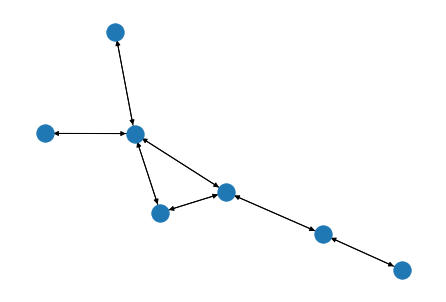

In [25]:
D = nx.to_networkx_graph(A,create_using=nx.DiGraph())
nx.draw(D)

Let's see how the molecule looks in 2D according to RDKit

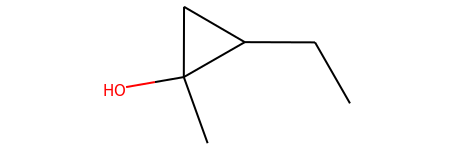

In [24]:
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole
m

Let's repeat this for all molecules

In [ ]:
from torch_geometric.data import Data, DataLoader
data_list = []
featurizer = RDKitDescriptors()

for m in mols:
    mol_featurized = featurizer.featurize([m])
    A = GetAdjacencyMatrix(m)
    edge_index = create_edge_index(A)
    d = Data(x=torch.tensor(mol_featurized), edge_index=torch.tensor(edge_index)) 
    data_list.append(d)

In [ ]:
loader = DataLoader(data_list, batch_size=32)

# Setting Up Graph Convolutional Network

In [38]:
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(111, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)